In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
#pip install git+https://github.com/KindXiaoming/pykan.git
import sys


In [ ]:
import random
import numpy as np
import torch
import os

def set_global_seed(seed=42):
    """Set seed for reproducibility across NumPy, PyTorch, and OS operations."""
    
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # If using CUDA
    
    # Ensure deterministic behavior in PyTorch (optional, can slow training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    # Set environment variable for other libraries
    os.environ["PYTHONHASHSEED"] = str(seed)

# Set global seed
set_global_seed(42)


In [2]:
test_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_X_data.csv")
train_data_X = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_X_data.csv")
test_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_test_data_y_data.csv")
train_labels_encoded = pd.read_csv(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\processed_train_data_y_data.csv")

In [3]:
train_labels_encoded.value_counts()

0
6    56000
5    40000
3    33393
4    18184
2    12264
7    10491
0     2000
1     1746
8     1133
9      130
Name: count, dtype: int64

In [4]:
target_distribution = {
    0: 20000,  # Class 0 should have 56000 samples
    1: 20000,  # Class 1 should have 56000 samples
    2: 30000,  # Class 2 should have 56000 samples
    3: 34000,  # Class 3 should have 56000 samples
    4: 30000,  # Class 4 should have 56000 samples
    5: 41000,  # Class 5 should have 56000 samples
    6: 56000,  # Class 6 should have 56000 samples
    7: 30000,  # Class 7 should have 56000 samples
    8: 20000,  # Class 8 should have 56000 samples
    9: 10000,  # Class 9 should have 56000 samples
}

# Resampling

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import numpy as np

# Current class distribution
unique, counts = np.unique(train_labels_encoded, return_counts=True)
class_distribution = dict(zip(unique, counts))

majority_class = 6
majority_target_size = class_distribution[majority_class] // 3

# Define the target size for the minority classes (e.g., match the majority target size)
target_distribution = {cls: majority_target_size for cls in unique}

# Step 1: Under-sample the majority class
under_sampler = RandomUnderSampler(sampling_strategy={majority_class: majority_target_size}, random_state=42)
#train_data_X, train_labels_encoded = under_sampler.fit_resample(train_data_X, train_labels_encoded)

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import numpy as np

# Current class distribution
unique, counts = np.unique(train_labels_encoded, return_counts=True)
class_distribution = dict(zip(unique, counts))

majority_class = 5
majority_target_size = class_distribution[majority_class] // 3

# Define the target size for the minority classes (e.g., match the majority target size)
target_distribution = {cls: majority_target_size for cls in unique}

# Step 1: Under-sample the majority class
under_sampler = RandomUnderSampler(sampling_strategy={majority_class: majority_target_size}, random_state=42)
#train_data_X, train_labels_encoded = under_sampler.fit_resample(train_data_X, train_labels_encoded)

In [7]:
train_labels_encoded.value_counts()

0
6    56000
5    40000
3    33393
4    18184
2    12264
7    10491
0     2000
1     1746
8     1133
9      130
Name: count, dtype: int64

In [8]:
from imblearn.under_sampling import EditedNearestNeighbours

In [9]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
#ENN reduces the majority class by keeping only well separated instances
enn = EditedNearestNeighbours(sampling_strategy = "majority", n_neighbors = 3)
#train_data_X, train_data_y = enn.fit_resample(train_data_X, train_labels_encoded)

In [10]:
#train_data_y.value_counts()

In [11]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy = "minority", random_state=42, n_neighbors= 3)
#train_data_X,train_data_y = adasyn.fit_resample(train_data_X, train_data_y)

In [12]:
from imblearn.combine import SMOTEENN

# Combine SMOTE (oversampling) and ENN (cleaning majority class)
#smote_enn = SMOTEENN(sampling_strategy="not majority", enn = enn, random_state=42,n_neighbors = 5)

# Apply SMOTEENN
#train_data_X, train_data_y = smote_enn.fit_resample(train_data_X, train_data_y)

# Check the class distribution after resampling
from collections import Counter
#print(f"Class distribution after resampling: {Counter(train_data_y)}")

In [13]:
train_data_y = train_labels_encoded

In [14]:
train_data_y.value_counts()

0
6    56000
5    40000
3    33393
4    18184
2    12264
7    10491
0     2000
1     1746
8     1133
9      130
Name: count, dtype: int64

# Feature Selection

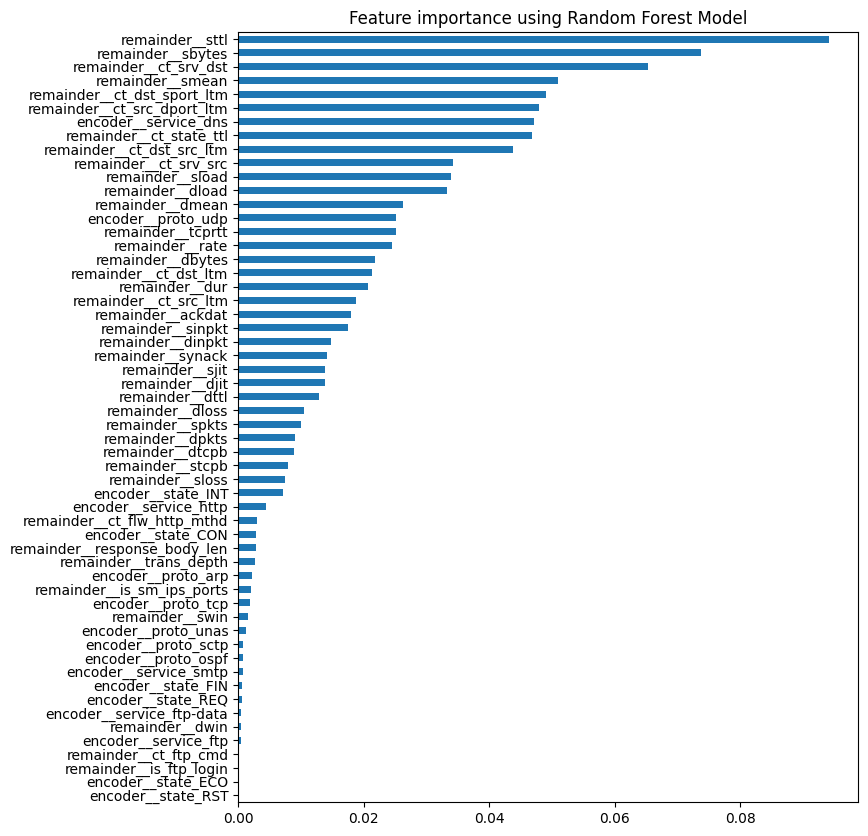

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=15)
numeric_cols = train_data_X.select_dtypes(include = "number")
rf_classifier.fit(numeric_cols, train_data_y.values.ravel())

feature_importances = pd.Series(rf_classifier.feature_importances_, index=numeric_cols.columns)

def plot_importance(coef, name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind="barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

plot_importance(feature_importances, 'Random Forest')

In [16]:
feature_importances

encoder__proto_arp              0.002289
encoder__proto_ospf             0.000760
encoder__proto_sctp             0.000771
encoder__proto_tcp              0.001969
encoder__proto_udp              0.025228
encoder__proto_unas             0.001297
encoder__service_dns            0.047050
encoder__service_ftp            0.000409
encoder__service_ftp-data       0.000504
encoder__service_http           0.004399
encoder__service_smtp           0.000748
encoder__state_CON              0.002900
encoder__state_ECO              0.000027
encoder__state_FIN              0.000637
encoder__state_INT              0.007103
encoder__state_REQ              0.000588
encoder__state_RST              0.000013
remainder__dur                  0.020717
remainder__spkts                0.010003
remainder__dpkts                0.009122
remainder__sbytes               0.073659
remainder__dbytes               0.021778
remainder__rate                 0.024504
remainder__sttl                 0.094045
remainder__dttl 

In [17]:
top_40_features = [
    "sttl",
    "PC1",
    "dttl",
    "ct_dst_src_ltm",
    "ct_dst_ltm",
    "ct_dst_sport_ltm",
    "ct_state_ttl",
    "ct_src_dport_ltm",
    "ct_src_ltm",
    "ct_srv_dst",
    "ct_srv_src",
    "ackdat",
    "tcprtt",
    "sbytes",
    "smean",
    "dload",
    "rate",
    "dmean",
    "dur",
    "PC3",
    "PC10",
    "dbytes",
    "synack",
    "PC2",
    "ct_flw_http_mthd",
    "trans_depth",
    "PC4",
    "sload",
    "PC5",
    "sinpkt",
    "PC8",
    "spkts",
    "dpkts",
    "PC9",
    "sloss",
    "sjit",
    "PC7",
    "dloss",
    "dwin",
    "swin"
]

In [18]:
from sklearn.feature_selection import f_classif #computes ANOVA 
from sklearn.feature_selection import SelectKBest  #Orders f statistics and selects the Kbest ones

def anova_test():

    
    X_vars = train_data_X[train_data_X.select_dtypes(include='number').columns]
    
    y_var = train_data_y
    
    anova = SelectKBest(f_classif, k=40) #we choose to keep the 10 best ones, try different numbers
    
    
    X_anova = anova.fit_transform(X_vars, y_var)
    
    anova_results = pd.DataFrame({'Feature': X_vars.columns, 
                                  'F-value': anova.scores_,
                                  'p-value': anova.pvalues_})
    
    anova_results.sort_values(by='F-value', ascending=False, inplace=True)

    
    selected_features = pd.Series(anova.get_support(), index = X_vars.columns)
    features_to_use = [feature for feature, keep in selected_features.items() if keep]

    features_to_use_str = '", "'.join(features_to_use)
    
    return selected_features, anova_results, features_to_use_str,features_to_use

In [19]:
selected_features, anova_results, features_to_use_str,features_to_use = anova_test()

C:\Users\ADMIN\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [20]:
features = features_to_use

# Modelling

## Modelling EfficentKan

In [21]:
#train_X_tensor = torch.tensor(train_data_X[features].values, dtype=torch.float32).squeeze()
#test_X_tensor = torch.tensor(test_data_X[features].values, dtype=torch.float32).squeeze() #changed to have all features

train_X_tensor = torch.tensor(train_data_X[features_to_use].values, dtype=torch.float32).squeeze()
test_X_tensor = torch.tensor(test_data_X[features_to_use].values, dtype=torch.float32).squeeze()

train_Y_tensor = torch.tensor(train_data_y.values, dtype=torch.long).squeeze()

test_Y_tensor = torch.tensor(test_labels_encoded.values, dtype=torch.long).squeeze()
#a dictionary with the 4 datasets

In [22]:
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [23]:

# Create TensorDatasets
train_dataset = TensorDataset(train_X_tensor, train_Y_tensor)
test_dataset = TensorDataset(test_X_tensor, test_Y_tensor)


In [24]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Modelling with efficient Kan

In [25]:
#


In [26]:
from efficient_kan import KAN

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define model
model = KAN([40, 64, 10])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

# Define loss
criterion = nn.CrossEntropyLoss()

In [28]:
model.grid_size, model.spline_order

(5, 3)

In [38]:
from sklearn.model_selection import KFold

In [39]:
model = KAN([40, 10,10, 4,10],grid_size = 4, spline_order = 2, scale_noise=0.1, scale_base=0.2, scale_spline=0.2)

In [35]:
#model = KAN([40, 5,4, 2,10],grid_size = 4, spline_order = 2, scale_noise=0.1, scale_base=0.2, scale_spline=0.2)

In [36]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance
    f1_macro = f1_score(all_labels, all_preds, average='macro') * 100  # Macro F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}%, Macro_F1-Score: {f1_macro: .2f}%  \n")


In [41]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn = FocalLoss(alpha=0.5, gamma = 1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!") #wider network

Epoch 1
-------------------------------
loss: 0.440901  [    0/175341]
loss: 0.369255  [ 1600/175341]
loss: 0.382019  [ 3200/175341]
loss: 0.722621  [ 4800/175341]
loss: 0.332475  [ 6400/175341]
loss: 0.551266  [ 8000/175341]
loss: 0.702944  [ 9600/175341]
loss: 0.886902  [11200/175341]
loss: 0.751396  [12800/175341]
loss: 0.971538  [14400/175341]
loss: 0.460648  [16000/175341]
loss: 0.480023  [17600/175341]
loss: 0.547781  [19200/175341]
loss: 0.196432  [20800/175341]
loss: 0.738696  [22400/175341]
loss: 0.273961  [24000/175341]
loss: 0.529558  [25600/175341]
loss: 0.923234  [27200/175341]
loss: 0.718976  [28800/175341]
loss: 0.354098  [30400/175341]
loss: 0.311513  [32000/175341]
loss: 0.254862  [33600/175341]
loss: 0.334361  [35200/175341]
loss: 0.623524  [36800/175341]
loss: 0.195947  [38400/175341]
loss: 0.317851  [40000/175341]
loss: 0.157714  [41600/175341]
loss: 0.167166  [43200/175341]
loss: 0.580817  [44800/175341]
loss: 0.890907  [46400/175341]
loss: 0.452711  [48000/175341]

In [42]:
loss_fn = nn.CrossEntropyLoss()
#loss_fn = FocalLoss(alpha=0.5, gamma = 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.108906  [    0/175341]
loss: 0.257077  [ 1600/175341]
loss: 0.157798  [ 3200/175341]
loss: 0.374379  [ 4800/175341]
loss: 0.543363  [ 6400/175341]
loss: 0.352598  [ 8000/175341]
loss: 0.152844  [ 9600/175341]
loss: 0.585742  [11200/175341]
loss: 0.134135  [12800/175341]
loss: 0.201633  [14400/175341]
loss: 0.398789  [16000/175341]
loss: 0.625062  [17600/175341]
loss: 0.622505  [19200/175341]
loss: 0.392802  [20800/175341]
loss: 0.523022  [22400/175341]
loss: 0.254320  [24000/175341]
loss: 0.472264  [25600/175341]
loss: 0.597450  [27200/175341]
loss: 0.435735  [28800/175341]
loss: 0.232942  [30400/175341]
loss: 0.614634  [32000/175341]
loss: 0.314270  [33600/175341]
loss: 0.456164  [35200/175341]
loss: 0.712167  [36800/175341]
loss: 0.887913  [38400/175341]
loss: 1.154189  [40000/175341]
loss: 0.498494  [41600/175341]
loss: 0.567493  [43200/175341]
loss: 0.120993  [44800/175341]
loss: 0.500566  [46400/175341]
loss: 0.371071  [48000/175341]

In [43]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.399120  [    0/175341]
loss: 0.948359  [ 1600/175341]
loss: 0.530783  [ 3200/175341]
loss: 0.173955  [ 4800/175341]
loss: 0.204503  [ 6400/175341]
loss: 0.408930  [ 8000/175341]
loss: 0.437123  [ 9600/175341]
loss: 0.204299  [11200/175341]
loss: 0.326054  [12800/175341]
loss: 0.502620  [14400/175341]
loss: 0.935823  [16000/175341]
loss: 0.704344  [17600/175341]
loss: 0.290815  [19200/175341]
loss: 0.772285  [20800/175341]
loss: 0.484590  [22400/175341]
loss: 0.473952  [24000/175341]
loss: 0.257846  [25600/175341]
loss: 0.832144  [27200/175341]
loss: 0.710474  [28800/175341]
loss: 0.441708  [30400/175341]
loss: 0.583425  [32000/175341]
loss: 0.540367  [33600/175341]
loss: 0.438702  [35200/175341]
loss: 0.408068  [36800/175341]
loss: 0.255854  [38400/175341]
loss: 0.692375  [40000/175341]
loss: 0.826537  [41600/175341]
loss: 0.818552  [43200/175341]
loss: 0.734640  [44800/175341]
loss: 0.365135  [46400/175341]
loss: 0.567682  [48000/175341]

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=1e-4)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
from sklearn.metrics import f1_score

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0  # For accuracy tracking
    total = 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
        # Calculate accuracy
        _, predicted = torch.max(pred, 1)
        correct += (predicted == y).sum().item()
        total += y.size(0)
    

    accuracy = correct / total * 100
    print(f"Train Accuracy: {accuracy:.4f}%")

def test_loop(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
            # Collect all predictions and true labels for F1-score calculation
            all_preds.extend(pred.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    f1 = f1_score(all_labels, all_preds, average='weighted') * 100  # Weighted F1-score to handle class imbalance

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, F1-score: {f1:.2f}% \n")


In [ ]:
model = KAN([40, 20,6, 3,10],grid_size = 3, scale_noise=0.2)

In [ ]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
model = KAN([40, 15,6, 3,10],grid_size = 4, scale_noise=0.2)

In [ ]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
model = KAN([40, 10,6, 3,10],grid_size = 4, scale_noise=0.2)

In [ ]:
from torch.optim import lr_scheduler

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

In [ ]:
# Smoothing function using a moving average
def smooth_loss(losses, window_size=100):
    """
    Smooth the loss values using a moving average.
    :param losses: List of loss values.
    :param window_size: Size of the moving window.
    :return: Smoothed loss values.
    """
    smoothed_losses = np.convolve(losses, np.ones(window_size) / window_size, mode='valid')
    return smoothed_losses

# Plot the training loss over time
plt.figure(figsize=(10, 6))

# Smooth and plot training loss for each fold
for fold, losses in enumerate(all_losses):
    smoothed_loss = smooth_loss(losses, window_size=100)  # Adjust window_size as needed
    plt.plot(smoothed_loss, label=f'Fold {fold + 1}')

# Calculate and plot the average smoothed loss across folds
avg_loss = np.mean(all_losses, axis=0)
smoothed_avg_loss = smooth_loss(avg_loss, window_size=100)
plt.plot(smoothed_avg_loss, label='Average Loss', linewidth=2, color='black')

plt.xlabel('Mini-Batch Iteration')
plt.ylabel('Loss')
plt.title('Training Loss Over Mini-Batches (Smoothed)')
plt.legend()
plt.show()

In [ ]:
print(f"Total Mini-Batches per Epoch: {len(trainloader)}")

# Confusion Matrix

In [ ]:
import pickle
import pandas as pd

# Load the LabelEncoder object from the file
with open(r"C:\Users\ADMIN\Desktop\Thesis Space Desktop\Data After Preprocess\label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


# Now you can use the label_encoder object in the second notebook
original_class_labels = label_encoder.classes_

In [ ]:
original_labels_test = label_encoder.inverse_transform(test_labels_encoded.values.flatten())

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure the model is in evaluation mode
model.eval()

with torch.no_grad():
    y_pred = model(test_X_tensor)  # Forward pass
    y_pred = torch.argmax(y_pred, dim=1)  # Get class predictions

# Convert tensors to NumPy arrays for sklearn
y_pred = y_pred.cpu().numpy()
y_true = test_Y_tensor.cpu().numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class labels from the LabelEncoder
class_labels = label_encoder.classes_

fig, ax = plt.subplots(figsize=(12, 8))  #Creates both a figure and an ax

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues', values_format='d', ax=ax)

# Rotate axis labels for better visibility
plt.xticks(rotation=45)
plt.yticks(rotation=45)

# Show the plot
plt.show()

In [ ]:
import torch.nn.functional as F

with torch.no_grad():
    y_score = F.softmax(model(test_X_tensor), dim=1)

In [ ]:
np.average(y_score.numpy())

In [ ]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(train_data_y)
y_onehot_test = label_binarizer.transform(test_labels_encoded)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
from sklearn.metrics import RocCurveDisplay

display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [ ]:
import torch
import torch.nn as nn

class NeuralNetwork(nn.Module):
    def __init__(self, input_shape: int, hidden_units1: int, hidden_units2: int, hidden_units3: int, hidden_units4: int, output_shape: int):
        super().__init__()
        self.flatten = nn.Flatten()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_features=input_shape, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units1, out_features=hidden_units2),
        )

        self.linear_relu_stack2 = nn.Sequential(
            nn.Linear(in_features=hidden_units2, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units2, out_features=hidden_units3),
        )

        # **New Block Added Here**
        self.linear_relu_stack3 = nn.Sequential(
            nn.Linear(in_features=hidden_units3, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units3),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units3, out_features=hidden_units4),
        )

        self.linear_relu_stack4 = nn.Sequential(
            nn.Linear(in_features=hidden_units4, out_features=hidden_units4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units4, out_features=hidden_units4),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=hidden_units4, out_features=output_shape),
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        x = self.linear_relu_stack2(x)
        x = self.linear_relu_stack3(x)  # Pass through new block
        logits = self.linear_relu_stack4(x)  # Final output layer

        return logits



In [ ]:
model_test = NeuralNetwork(40,128,64,32,10,10)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

epochs = 200
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model_test, loss_fn, optimizer)
    test_loop(test_dataloader, model_test, loss_fn)
print("Done!")